In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

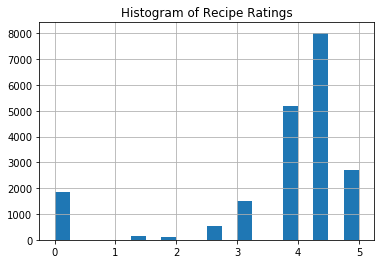

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [7]:
# count nulls
null_count = raw_data.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

There are non-finite values in the feature set that will cause pipeline cross-validation to throw value errors. They were all in the nutritional information features, so let's drop them

In [15]:
np.isfinite(X).all()

#cakeweek                True
#wasteless               True
22-minute meals          True
3-ingredient recipes     True
30 days of groceries     True
advance prep required    True
alabama                  True
alaska                   True
alcoholic                True
almond                   True
amaretto                 True
anchovy                  True
anise                    True
anniversary              True
anthony bourdain         True
aperitif                 True
appetizer                True
apple                    True
apple juice              True
apricot                  True
arizona                  True
artichoke                True
arugula                  True
asian pear               True
asparagus                True
aspen                    True
atlanta                  True
australia                True
avocado                  True
back to school           True
                         ... 
walnut                   True
wasabi                   True
washington

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Feature sets
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'],1)
X = X.dropna(axis=1, how='all')

# Target
Y = raw_data.rating.apply(lambda x: 1 if x>2.5 else 0)

# pipeline construction
# ANOVA F-value between label/feature for classification tasks.
# Select features according to the k highest scores.
anova = SelectKBest(f_classif, k=30)
svm = SVC(kernel='linear')
anova_svm = make_pipeline(anova, svm)

# fitting & cross validation
anova_svm.fit(X,Y)
scores = cross_val_score(anova_svm, X, Y, cv=5)

# listing selected features
#features = anova.get_support(indices=True)
feature_names = list(X.columns[anova.get_support(indices=True)])
# 1st way to get the list
#vector_names = list(X.columns[anova.get_support(indices=True)])
#2nd way
#X.columns[anova.get_support(indices=True)].tolist()

print('Cross validation scores: {}'.format(scores))
print('Cross validation score averaged across folds: {:.2%}'.format(scores.mean()))
print('Selected features: {}'.format(feature_names))

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [153 254 256 269 308 351 420 576 591 614 666] are constant.
  UserWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 25 105 162 243 288 567 599 643] are constant.
  UserWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  1  47 183 196 199 202 221 285 335 394 495 652 653] are constant.
  UserWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\feature_selection\univaria

Cross validation scores: [0.87337986 0.8755611  0.87531172 0.87680798 0.87680798]
Cross validation score averaged across folds: 87.56%
Selected features: ['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink', 'fall', 'fortified wine', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'liqueur', 'non-alcoholic', 'onion', 'peanut free', 'pernod', 'quick & easy', 'roast', 'rum', 'sauté', 'soy free', 'spirit', 'tree nut free', 'weelicious', 'winter']


## PCA way of choosing the best variables

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
sns.set()

raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [29]:
# separate rating 
raw_data['good'] = raw_data.rating.apply(lambda x: 1 if x > 2.5 else 0)
raw_data

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey,good
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,The Best Blts,4.375,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,Ham and Spring Vegetable Salad with Shallot Vi...,4.375,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Spicy-Sweet Kumquats,3.750,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,Korean Marinated Beef,4.375,170.0,7.0,10.0,1272.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,Ham Persillade with Mustard Potato Salad and M...,3.750,602.0,23.0,41.0,1696.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [30]:
Y = raw_data.good
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'],1)

In [31]:
# fitting PCA and selecting top 30
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X)
X_pca = pca.transform(X)

In [32]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_pca, Y)
svc.score(X_pca, Y)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_pca, Y, cv=5)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([1., 1., 1., 1., 1.])

In [34]:
cross_val_score(svc, X_pca, Y, cv=5).mean()

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

1.0

## Instead of PCA, using correlation table to choose the top 30

In [36]:
raw_data['good'] = pd.concat([pd.get_dummies(raw_data.good, prefix='good', drop_first=True)],1)

In [37]:
# using correlation table to choose the top 30 
num_cols = raw_data.select_dtypes(include=['int','float'])
c = num_cols.corr().abs()
c.sort_values(by='rating', ascending=False).head(30)

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
rating,1.000000,0.007882,0.013980,0.007236,0.008177,0.003147,0.006771,0.011155,0.047840,0.006717,...,0.003016,0.023807,0.006771,0.007179,0.002294,0.009179,0.051770,0.037606,0.006739,0.022599
drink,0.241388,0.003951,0.005884,0.003820,0.004246,0.004142,0.001691,0.006974,0.008791,0.004474,...,0.008459,0.017362,0.001691,0.004142,0.029405,0.002929,0.004474,0.003054,0.007373,0.036521
alcoholic,0.224767,0.003423,0.005146,0.003324,0.003667,0.003606,0.001472,0.006072,0.007654,0.003895,...,0.007365,0.032720,0.001472,0.003606,0.025602,0.002550,0.003895,0.007795,0.006420,0.031798
house & garden,0.217911,0.002487,0.003424,0.002359,0.002613,0.002648,0.001081,0.004458,0.005620,0.002860,...,0.005408,0.023088,0.001081,0.002648,0.013287,0.001872,0.002860,0.005723,0.004714,0.016915
gin,0.191400,0.001805,0.002655,0.001726,0.001971,0.001847,0.000754,0.003110,0.003920,0.001995,...,0.003772,0.017558,0.000754,0.001847,0.013113,0.001306,0.001995,0.003992,0.003288,0.016287
spirit,0.146625,0.001730,0.002576,0.001649,0.001800,0.001818,0.000742,0.003061,0.003859,0.001964,...,0.003713,0.017281,0.000742,0.001818,0.012906,0.001285,0.001964,0.003929,0.003236,0.016030
cocktail,0.140723,0.002278,0.003415,0.002194,0.002443,0.002405,0.000982,0.004049,0.005103,0.002597,...,0.004911,0.020572,0.000982,0.002405,0.017071,0.001700,0.002597,0.005197,0.004280,0.021201
cocktail party,0.140482,0.004116,0.005995,0.003925,0.004314,0.004275,0.001745,0.007198,0.009074,0.004618,...,0.008731,0.012553,0.001745,0.004275,0.021502,0.003023,0.004618,0.009241,0.007610,0.034823
bitters,0.137368,0.001281,0.001909,0.001173,0.001397,0.001381,0.000564,0.002326,0.002932,0.001492,...,0.002821,0.013129,0.000564,0.001381,0.009806,0.000977,0.001492,0.002985,0.002459,0.012179
bon appétit,0.124549,0.008150,0.012206,0.007551,0.008330,0.016179,0.006604,0.027241,0.034339,0.017476,...,0.010378,0.008533,0.007552,0.016179,0.000023,0.011439,0.014632,0.016231,0.009306,0.009562


In [38]:
c.sort_values(by='rating', ascending=False).head(35)

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
rating,1.000000,0.007882,0.013980,0.007236,0.008177,0.003147,0.006771,0.011155,0.047840,0.006717,...,0.003016,0.023807,0.006771,0.007179,0.002294,0.009179,0.051770,0.037606,0.006739,0.022599
drink,0.241388,0.003951,0.005884,0.003820,0.004246,0.004142,0.001691,0.006974,0.008791,0.004474,...,0.008459,0.017362,0.001691,0.004142,0.029405,0.002929,0.004474,0.003054,0.007373,0.036521
alcoholic,0.224767,0.003423,0.005146,0.003324,0.003667,0.003606,0.001472,0.006072,0.007654,0.003895,...,0.007365,0.032720,0.001472,0.003606,0.025602,0.002550,0.003895,0.007795,0.006420,0.031798
house & garden,0.217911,0.002487,0.003424,0.002359,0.002613,0.002648,0.001081,0.004458,0.005620,0.002860,...,0.005408,0.023088,0.001081,0.002648,0.013287,0.001872,0.002860,0.005723,0.004714,0.016915
gin,0.191400,0.001805,0.002655,0.001726,0.001971,0.001847,0.000754,0.003110,0.003920,0.001995,...,0.003772,0.017558,0.000754,0.001847,0.013113,0.001306,0.001995,0.003992,0.003288,0.016287
spirit,0.146625,0.001730,0.002576,0.001649,0.001800,0.001818,0.000742,0.003061,0.003859,0.001964,...,0.003713,0.017281,0.000742,0.001818,0.012906,0.001285,0.001964,0.003929,0.003236,0.016030
cocktail,0.140723,0.002278,0.003415,0.002194,0.002443,0.002405,0.000982,0.004049,0.005103,0.002597,...,0.004911,0.020572,0.000982,0.002405,0.017071,0.001700,0.002597,0.005197,0.004280,0.021201
cocktail party,0.140482,0.004116,0.005995,0.003925,0.004314,0.004275,0.001745,0.007198,0.009074,0.004618,...,0.008731,0.012553,0.001745,0.004275,0.021502,0.003023,0.004618,0.009241,0.007610,0.034823
bitters,0.137368,0.001281,0.001909,0.001173,0.001397,0.001381,0.000564,0.002326,0.002932,0.001492,...,0.002821,0.013129,0.000564,0.001381,0.009806,0.000977,0.001492,0.002985,0.002459,0.012179
bon appétit,0.124549,0.008150,0.012206,0.007551,0.008330,0.016179,0.006604,0.027241,0.034339,0.017476,...,0.010378,0.008533,0.007552,0.016179,0.000023,0.011439,0.014632,0.016231,0.009306,0.009562


In [39]:
# features is the top 30 
X = raw_data[['drink', 'alcoholic', 'house & garden', 'gin', 'spirit', 'cocktail', 
              'cocktail party', 'bitters', 'bon appétit', 'harpercollins', 'peanut free', 'soy free',
              'liqueur', 'rum', 'tree nut free', 'non-alcoholic', 'bake', 'condiment', 
              'roast', 'fall', 'sauté', 'brandy', 'fortified wine', 'pernod',
              'créme de cacao', 'dinner', 'weelicious', 'chartreuse', 'kosher', 'lime juice']]

Y = raw_data.good

In [40]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X,Y)
svc.score(X,Y)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8777678037103531

In [41]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, Y, cv=5)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([0.87462612, 0.87755611, 0.87581047, 0.87755611, 0.87630923])

In [42]:
cross_val_score(svc, X, Y, cv=5).mean()

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

0.8763716083669191